Installing Requirements

In [ ]:
# Install necessary packages
%pip install mediapipe tensorflow opencv-python numpy


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Access Dataset

In [ ]:
#replace the required parts here with your own API key and project details from Roboflow
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("YOUR_WORKSPACE").project("YOUR_PROJECT")
version = project.version(1)
dataset = version.download("yolov8")


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
loading Roboflow workspace...
loading Roboflow project...


Exploring Dataset Structure

In [3]:
import os

dataset_folder = "Video-Call-ASL-Signs-1"

# Print all files and folders inside the dataset directory
for root, dirs, files in os.walk(dataset_folder):
    print(f"Directory: {root}")
    print("  Subdirectories:", dirs)
    print("  Files:", files)

Directory: Video-Call-ASL-Signs-1
  Subdirectories: ['valid', 'test', 'train']
  Files: ['README.roboflow.txt', 'README.dataset.txt', 'data.yaml']
Directory: Video-Call-ASL-Signs-1/valid
  Subdirectories: ['images', 'labels']
  Files: []
Directory: Video-Call-ASL-Signs-1/valid/images
  Subdirectories: []
  Files: ['video4255639387_mp4-78_jpg.rf.2dbd8cc0908ebf0780047df0055adfa1.jpg', 'video4255639387_mp4-99_jpg.rf.a03beaf9e7c940af2a68d3a454881392.jpg', 'video4255639387_mp4-119_jpg.rf.7bb3eaa330c982896348647e6870a562.jpg', 'video3255639387_mp4-154_jpg.rf.8427820e3811ee07c228945c35796e22.jpg', 'video4255639387_mp4-148_jpg.rf.7446eeddea11a17f56a71e62bc7ee0db.jpg', 'video3255639387_mp4-151_jpg.rf.e865344ddb38fc4f82f75bfe6d7ab5aa.jpg', 'video4255639387_mp4-41_jpg.rf.a8deb042c24000c3a802f8e437ebf3ef.jpg', 'video4255639387_mp4-121_jpg.rf.29fd2ce82be21cc5dae34d7228bff5de.jpg', 'video4255639387_mp4-89_jpg.rf.62ae3405cdea58cf6c3a396d87bc46a4.jpg', 'video3255639387_mp4-81_jpg.rf.798c30a03d1824c3ec

Dataset Directory Check

In [4]:
import os

dataset_folder = "Video-Call-ASL-Signs-1"

# Define image and label directories
image_dir = os.path.join(dataset_folder, "train", "images")
label_dir = os.path.join(dataset_folder, "train", "labels")

# Check if they exist
print("Image directory exists:", os.path.exists(image_dir))
print("Label directory exists:", os.path.exists(label_dir))

Image directory exists: True
Label directory exists: True


Replacing the Class IDs with Actual Class Names

In [5]:
# Replace these with your actual class names in order (class ID 0, 1, 2...)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
          'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

label_map = {i: label for i, label in enumerate(labels)}

View Sample Label File Content

In [6]:
label_file = os.listdir(label_dir)[0]
with open(os.path.join(label_dir, label_file), 'r') as f:
    print(f"Sample label file content ({label_file}):")
    print(f.read())

Sample label file content (WhatsApp-Video-2023-03-07-at-22_13_30_mp4-39_jpg.rf.127e3a876bb40163c52b037ac9dc9cfb.txt):
13 0.5388518518518519 0.4943472222222222 0.23048148148148148 0.3636944444444445


Initialize MediaPipe for Landmark Extraction

In [7]:
import cv2
import mediapipe as mp
import numpy as np

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def extract_landmarks_from_image(img_path):
    image = cv2.imread(img_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        return np.array(landmarks)
    else:
        return None

I0000 00:00:1752807208.809589 2449630 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4


Extract Landmarks from Dataset Images and Labels

In [8]:
data = []
classes = []

for label_file in os.listdir(label_dir):
    # Get base name without extension
    base_name = os.path.splitext(label_file)[0]

    # Image path
    img_path = os.path.join(image_dir, base_name + ".jpg")
    if not os.path.exists(img_path):
        continue

    # Read label
    with open(os.path.join(label_dir, label_file), 'r') as f:
        line = f.readline()
        if not line:
            continue
        class_id = int(line.split()[0])

    # Extract landmarks
    landmarks = extract_landmarks_from_image(img_path)
    if landmarks is not None:
        data.append(landmarks)
        classes.append(class_id)

X = np.array(data)
y = np.array(classes)

print("Total samples:", len(X))
print("Feature shape:", X.shape)
print("Label shape:", y.shape)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752807208.830998 2450284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752807208.839323 2450291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.


Total samples: 585
Feature shape: (585, 63)
Label shape: (585,)


Show Total Samples Extracted

In [9]:
print("Total samples extracted:", len(X))

Total samples extracted: 585


Display a Sample Image

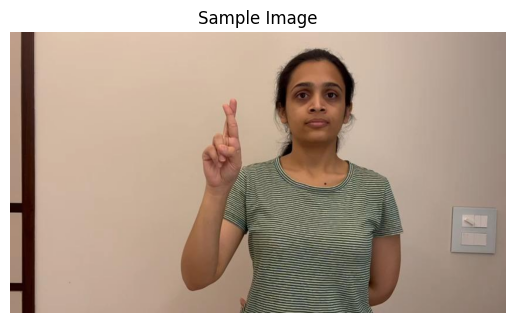

In [10]:
import cv2
import matplotlib.pyplot as plt

# Pick a sample image
sample_img_path = os.path.join(image_dir, os.listdir(image_dir)[0])
sample_img = cv2.imread(sample_img_path)

# Show image
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Sample Image")
plt.axis("off")
plt.show()

Extract Landmarks from Sample Image

In [11]:
landmarks = extract_landmarks_from_image(sample_img_path)
if landmarks is not None:
    print("Landmarks extracted:", landmarks.shape)
else:
    print("No landmarks detected in sample image.")

Landmarks extracted: (63,)


Print Dataset Shapes and Sample Landmarks

In [12]:
print("Feature shape:", X.shape)
print("Unique labels:", np.unique(y))
print("Sample landmarks:", X[0])

Feature shape: (585, 63)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Sample landmarks: [ 5.59531987e-01  6.06792927e-01 -2.84680482e-07  5.95620632e-01
  5.64942956e-01 -3.20814513e-02  6.10580921e-01  5.23898602e-01
 -5.55182062e-02  5.81822813e-01  5.31730533e-01 -7.61639252e-02
  5.48827052e-01  5.57552516e-01 -9.49074402e-02  5.73829055e-01
  3.83136630e-01 -3.86070423e-02  5.69467127e-01  4.21672136e-01
 -7.65948892e-02  5.69370687e-01  4.91461962e-01 -1.00574352e-01
  5.73584020e-01  5.42376220e-01 -1.11744583e-01  5.28509676e-01
  3.94162714e-01 -3.77888158e-02  5.22955537e-01  4.43669498e-01
 -7.40177855e-02  5.36159933e-01  5.12944758e-01 -8.56476948e-02
  5.50407052e-01  5.54139137e-01 -8.59675631e-02  4.90202844e-01
  4.27878082e-01 -4.12256643e-02  4.88075435e-01  4.95391667e-01
 -7.45799392e-02  5.13870716e-01  5.56578517e-01 -7.57027864e-02
  5.35292566e-01  5.80806017e-01 -6.81630075e-02  4.62957203e-01
  4.71294403e-01

Normalize Landmarks Relative to Wrist

In [13]:
def normalize_landmarks(landmarks):
    wrist = landmarks[0:3]
    normalized = landmarks - np.tile(wrist, 21)
    return normalized

# Apply normalization
X = np.array([normalize_landmarks(x) for x in X])

Define and Compile the ASL Sign Detection Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(len(labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,485 (76.11 KB)

 Trainable params: 19,485 (76.11 KB)

 Non-trainable params: 0 (0.00 B)

Augment Landmark Data with Noise

In [15]:
%pip install scikit-learn

def augment_landmarks(landmarks, noise_level=0.02):
    return landmarks + np.random.normal(0, noise_level, size=landmarks.shape)

# Augment data
X_augmented = np.array([augment_landmarks(x) for x in X])
y_augmented = y.copy()

# Combine original and augmented data
X = np.vstack([X, X_augmented])
y = np.hstack([y, y])

# Shuffle again
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Split Data into Train and Test Sets

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the Model with Callbacks

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0553 - loss: 3.3437 - val_accuracy: 0.1197 - val_loss: 3.2151 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1052 - loss: 3.1928 - val_accuracy: 0.1282 - val_loss: 2.9353 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1492 - loss: 2.9516 - val_accuracy: 0.1325 - val_loss: 2.6341 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1736 - loss: 2.7391 - val_accuracy: 0.2821 - val_loss: 2.3358 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2152 - loss: 2.5500 - val_accuracy: 0.3291 - val_loss: 2.0902 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2361 - loss: 2.3931 - val_accuracy: 0.3419 - val_loss: 1.9003 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2580 - loss: 2.1953 - val_acc

Save the Trained Model

In [25]:
model.save("asl_hand_model.h5")

Plot Training Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Accuracy: 0.7500
F1 Score: 0.7089

Classification Report:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.33      0.50         3
           2       0.75      1.00      0.86         3

    accuracy                           0.75         8
   macro avg       0.81      0.78      0.72         8
weighted avg       0.82      0.75      0.71         8



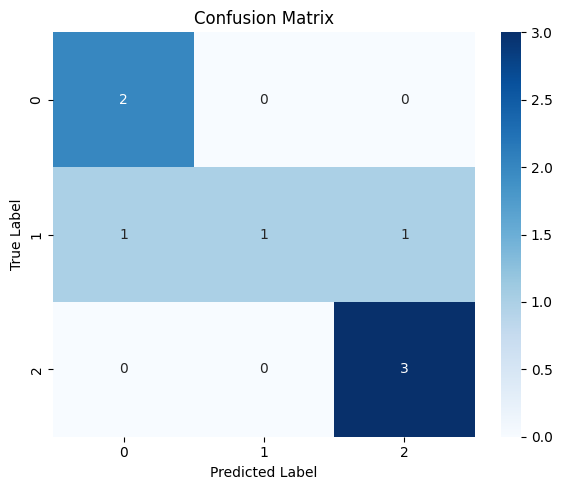

In [5]:
%pip install scikit-learn matplotlib seaborn

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Example dummy labels (replace with your real data)
y_true = [0, 1, 2, 2, 0, 1, 1, 2]
y_pred = [0, 0, 2, 2, 0, 1, 2, 2]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # use 'macro' or 'micro' as needed
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
